In [1]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from collections import Counter
import numpy as np
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import StatePreparation


In [2]:
#backend = AerProvider().get_backend("qasm_simulator")


service  = QiskitService(str(Path.cwd() / ".env"))
backend = service.get_least_busy_backend()

Connected to IBM Quantum.


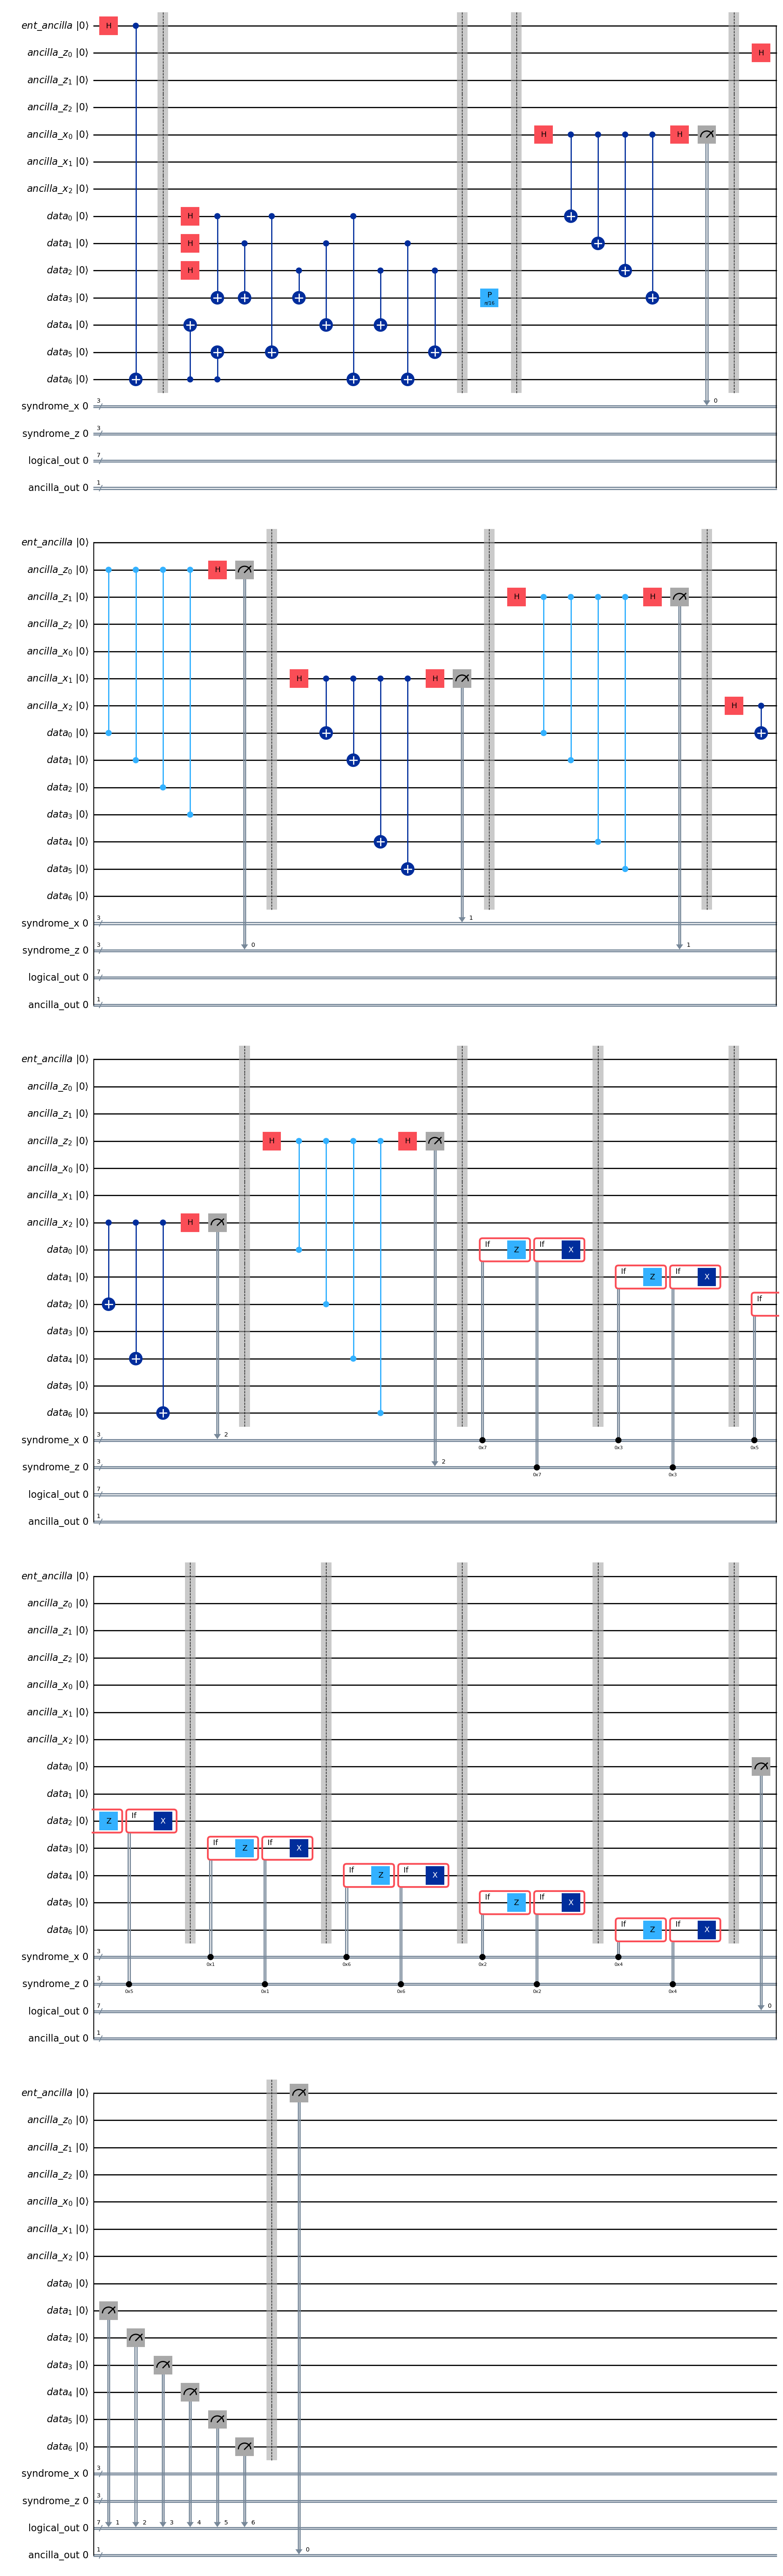

In [ ]:
# Define registers
entanglement_ancilla = QuantumRegister(1, 'ent_ancilla')
data = QuantumRegister(7, 'data')
ancilla_x = QuantumRegister(3, 'ancilla_x')
ancilla_z = QuantumRegister(3, 'ancilla_z')
syndrome_x = ClassicalRegister(3, 'syndrome_x')
syndrome_z = ClassicalRegister(3, 'syndrome_z')
logical_out = ClassicalRegister(7, 'logical_out')
ancilla_out = ClassicalRegister(1, 'ancilla_out')

# Create circuit with all registers
circuit = QuantumCircuit(entanglement_ancilla, ancilla_z, ancilla_x, data, 
                         syndrome_x, syndrome_z, logical_out, ancilla_out)

# STEP 1: Create entangled state between ancilla and input qubit (data[6])
# |0ᴀ⟩|0⟩ + |1ᴀ⟩|1⟩
circuit.h(entanglement_ancilla[0])  # Put ancilla in superposition
circuit.cx(entanglement_ancilla[0], data[6])  # Entangle ancilla with data[6]
circuit.barrier()

# STEP 2: Apply Steane encoding to the data register
# This transforms the entangled state to: |0ᴀ⟩|0ᴌ⟩ + |1ᴀ⟩|1ᴌ⟩
circuit.h(data[0])  
circuit.h(data[1])
circuit.h(data[2])
circuit.cx(data[6], data[4])
circuit.cx(data[6], data[5])
circuit.cx(data[0], data[3])
circuit.cx(data[1], data[3])
circuit.cx(data[0], data[5])
circuit.cx(data[2], data[3])
circuit.cx(data[1], data[4])
circuit.cx(data[0], data[6])
circuit.cx(data[2], data[4])
circuit.cx(data[1], data[6])
circuit.cx(data[2], data[5])
circuit.barrier()

phi = np.pi/16  # Phase angle
circuit.p(phi, data[3])  # Apply phase error to qubit 3


stabilizers = [(0,1,2,3), (0,1,4,5), (0,2,4,6)]
for i, (q0, q1, q2, q3) in enumerate(stabilizers):
    circuit.barrier()
    circuit.h(ancilla_x[i])
    # Reverse the control-target order for the CNOT gates:
    circuit.cx(ancilla_x[i], data[q0])
    circuit.cx(ancilla_x[i], data[q1])
    circuit.cx(ancilla_x[i], data[q2])
    circuit.cx(ancilla_x[i], data[q3])
    circuit.h(ancilla_x[i])
    circuit.measure(ancilla_x[i], syndrome_x[i])
    circuit.barrier()
    circuit.h(ancilla_z[i])
    circuit.cz(data[q0], ancilla_z[i])
    circuit.cz(data[q1], ancilla_z[i])
    circuit.cz(data[q2], ancilla_z[i])
    circuit.cz(data[q3], ancilla_z[i])
    circuit.h(ancilla_z[i])
    circuit.measure(ancilla_z[i], syndrome_z[i])

corrections = [
    (0b111, 0),  # Qubit 0 -> Syndrome 111
    (0b011, 1),  # Qubit 1 -> Syndrome 011
    (0b101, 2),  # Qubit 2 -> Syndrome 101
    (0b001, 3),  # Qubit 3 -> Syndrome 001 
    (0b110, 4),  # Qubit 4 -> Syndrome 110
    (0b010, 5),  # Qubit 5 -> Syndrome 010
    (0b100, 6)   # Qubit 6 -> Syndrome 100
]

circuit.barrier()

# Correct for phase-flip (Z) errors using the syndrome from the X stabilizers.
for pattern, qubit in corrections:
    with circuit.if_test((syndrome_x, pattern)):
        circuit.z(data[qubit])
    with circuit.if_test((syndrome_z, pattern)):
        circuit.x(data[qubit])
    circuit.barrier()
    
# Measure the logical state
for i in range(7):
    circuit.measure(data[i], logical_out[i])


circuit.barrier()
circuit.measure(entanglement_ancilla[0], ancilla_out[0])
circuit.draw(output='mpl', initial_state=True)



In [4]:
# Simulation parameters
NUM_SHOTS = 20000
simulator = AerSimulator()  # Use AerSimulator as in your existing code
job = simulator.run(circuit, shots=NUM_SHOTS)
result = job.result()
counts = result.get_counts()
#CodeWord = list(counts.keys())
CodeWordNoSymptom = list({word[:7] for word in counts.keys()})
logic_1 = ['1111111', '0101010', '1001100', '0011001', '1110000', '0100101', '1000011', '0010110']
logic_0 = ["0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"]
print(counts)

{'1 1000011 000 000': 1218, '1 0011001 000 000': 1185, '1 1110000 000 000': 1235, '0 1011010 000 000': 1240, '0 0111100 000 000': 1302, '0 0001111 000 000': 1231, '0 1101001 000 001': 13, '1 1001100 000 001': 13, '1 0010110 000 000': 1244, '1 0101010 000 001': 14, '0 1010101 000 000': 1199, '1 0010110 000 001': 8, '1 1001100 000 000': 1261, '0 1101001 000 000': 1243, '1 1111111 000 000': 1274, '0 0000000 000 000': 1225, '0 1100110 000 000': 1254, '0 0110011 000 000': 1268, '0 1010101 000 001': 13, '1 0101010 000 000': 1204, '1 0100101 000 000': 1241, '0 1011010 000 001': 14, '0 0111100 000 001': 9, '1 1110000 000 001': 12, '1 0100101 000 001': 15, '0 0000000 000 001': 12, '0 1100110 000 001': 11, '1 0011001 000 001': 8, '0 0001111 000 001': 8, '1 1111111 000 001': 9, '0 0110011 000 001': 10, '1 1000011 000 001': 7}


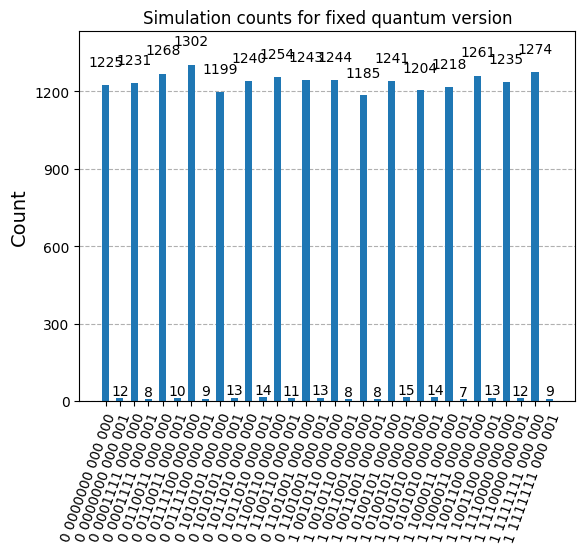

In [5]:
plot_histogram(result.get_counts(), title='Simulation counts for fixed quantum version')

* Classic error correcting version down below

In [6]:
NUM_SHOTS = 3000
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend)# optimization_level=3)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots=NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: d0kkdfd8jzxg008n5mj0, 
 Job Status: QUEUED


In [7]:
# Get results
result = job.result()
pub_result = result[0]

# Print measurement counts
print(f"Counts for 'syndrome_x' (phase flips): {pub_result.data.syndrome_x.get_counts()}")
print(f"Counts for 'syndrome_z' (bit flips): {pub_result.data.syndrome_z.get_counts()}")
print(f"Counts for 'logical_out' (data qubits): {pub_result.data.logical_out.get_counts()}")

Counts for 'syndrome_x' (phase flips): {'111': 365, '001': 384, '011': 393, '010': 363, '000': 350, '100': 362, '101': 382, '110': 401}
Counts for 'syndrome_z' (bit flips): {'100': 354, '011': 391, '111': 383, '110': 327, '101': 433, '010': 351, '000': 371, '001': 390}
Counts for 'logical_out' (data qubits): {'1000110': 30, '0001010': 35, '1010011': 23, '1110100': 14, '0111001': 22, '0110000': 23, '0110110': 31, '0100001': 28, '0010001': 27, '0011111': 14, '1010111': 18, '1001101': 18, '0110001': 29, '1100101': 28, '0011110': 20, '0110010': 27, '1110000': 22, '1100001': 30, '1000000': 43, '1101100': 14, '1100111': 40, '0100111': 30, '1110010': 17, '0000011': 32, '1000001': 34, '1011001': 14, '1111011': 13, '1111000': 6, '1101111': 26, '0001111': 24, '1100011': 23, '0001001': 28, '0010111': 17, '0100101': 42, '0101111': 37, '0010011': 19, '1011011': 14, '1011000': 12, '0100010': 27, '0010100': 47, '1010010': 24, '1000011': 35, '1010000': 28, '0101001': 16, '0001000': 31, '0110011': 19, 

In [8]:
service.get_usage()

{'period': {'start': '2025-05-01T00:00:00.000Z',
  'end': '2025-05-31T23:59:59.999Z'},
 'byInstance': [{'instance': 'ibm-q/open/main',
   'quota': 600,
   'usage': 191,
   'pendingJobs': 1,
   'maxPendingJobs': 3}]}

In [9]:
#print the type of the result logical out
print(type(pub_result.data.logical_out))

<class 'qiskit.primitives.containers.bit_array.BitArray'>


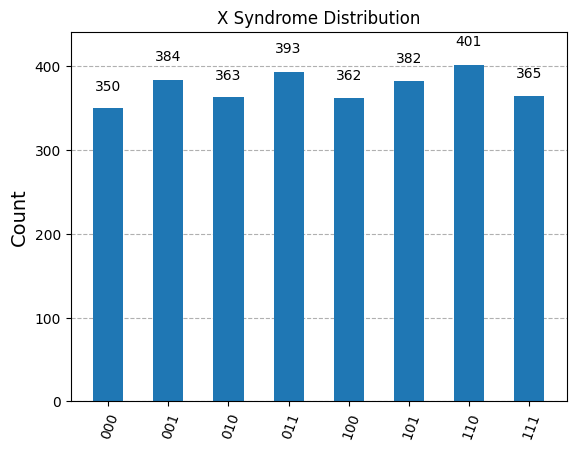

In [10]:

# Optional: Visualize the syndrome distributions
plot_histogram(pub_result.data.syndrome_x.get_counts(), title="X Syndrome Distribution")

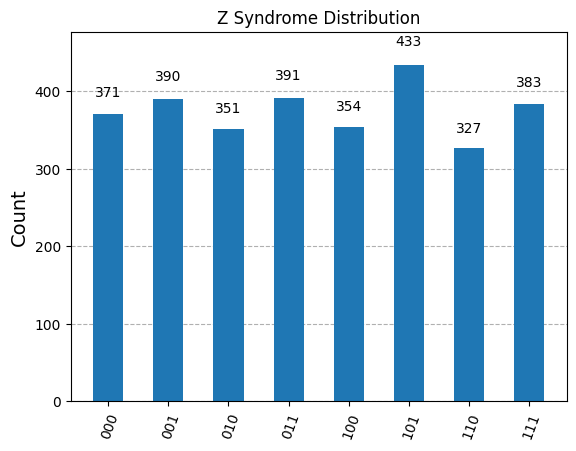

In [11]:
plot_histogram(pub_result.data.syndrome_z.get_counts(), title="Z Syndrome Distribution")


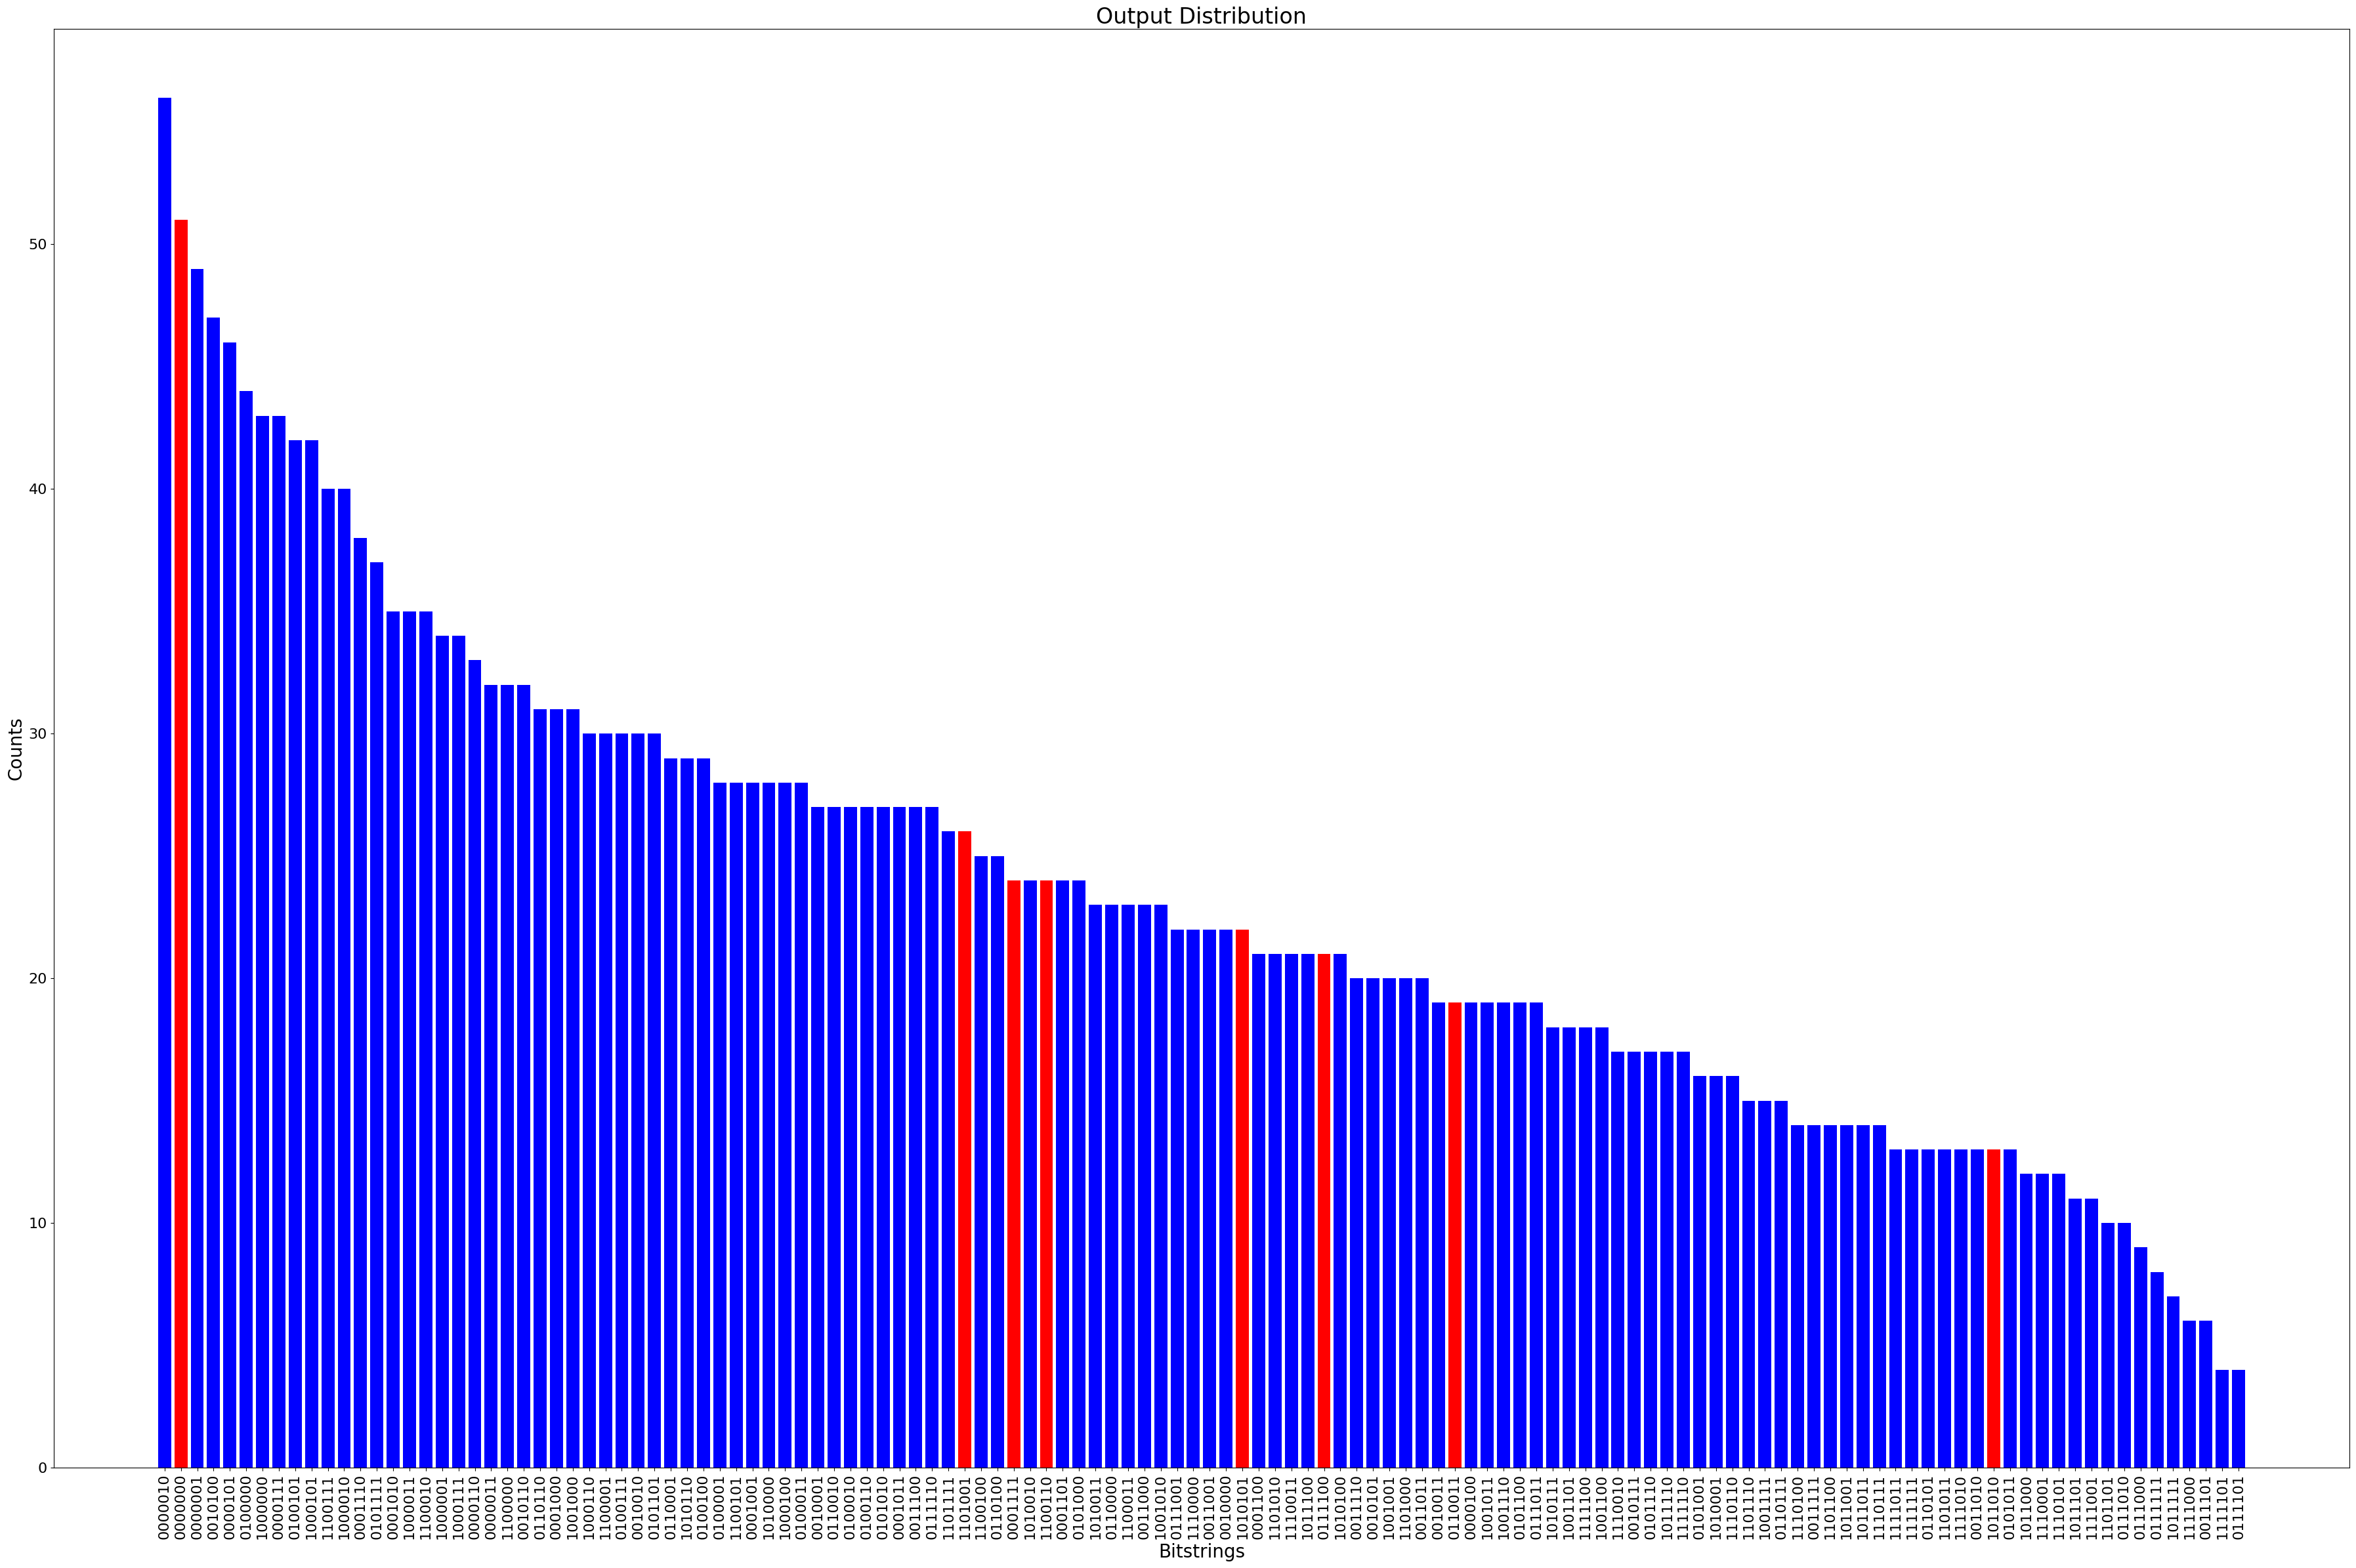

In [12]:
import matplotlib.pyplot as plt

steane_code_logic_0 = {"0000000", "1010101", "0110011", "1100110", 
                       "0001111", "1011010", "0111100", "1101001"}

# Get the counts data
counts = pub_result.data.logical_out.get_counts()

# Sort the counts for better visualization
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
colors = [
    "red" if key in steane_code_logic_0 
    else "blue" 
    for key in keys
]
# Create the bar chart
plt.figure(figsize=(36, 24))
plt.bar(keys, values, color=colors)

# Add labels and title
plt.xlabel("Bitstrings", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.title("Output Distribution", fontsize=24)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Calculate the total counts for the desired states in steane_code_logic_0
desired_counts = sum(counts[key] for key in steane_code_logic_0 if key in counts)

# Print the result
print(f"Total counts for desired states in steane_code_logic_0: {desired_counts}")

# Calculate the percentage of desired states
percentage = (desired_counts / NUM_SHOTS) * 100
print(f"Percentage of desired states: {percentage:.2f}%")

# Calculate the number of distinct values encountered
distinct_values = len(counts)
print(f"Number of distinct values encountered: {distinct_values}")

Total counts for desired states in steane_code_logic_0: 200
Percentage of desired states: 6.67%
Number of distinct values encountered: 128


In [14]:
# Convert logical_out BitArray to a probability vector

# Get counts from logical_out
logical_out_counts = pub_result.data.logical_out.get_counts()

# Calculate total shots
total_shots = sum(logical_out_counts.values())

# Create a probability vector
probability_vector = [count / total_shots for count in logical_out_counts.values()]

# Print the probability vector in a readable format
#print("Probability vector:")
#for i, prob in enumerate(probability_vector):
#    print(f"  Outcome {i + 1}: {prob:.6f}")

# Calculate and print the Shannon entropy
entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy: {entropy_value:.6f}")


Shannon Entropy: 6.861836
